<a href="https://colab.research.google.com/github/SwarajShinde/OCR-Using-CNN-RNN/blob/master/OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    207      0 --:--:-- --:--:-- --:--:--   207
100 8863k  100 8863k    0     0  6299k      0  0:00:01  0:00:01 --:--:-- 19.8M


In [2]:
!unzip -qq captcha_images_v2.zip


In [3]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

COnfig


In [5]:
Data_dir = "/content/captcha_images_v2"
batch_size = 8
image_width = 300
image_height = 75
num_workers = 8
epochs = 200
DEVICE = 'cuda'



DataSet 


In [6]:
import torch
import albumentations
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import numpy as np

from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

class OCRDataset(Dataset):
    def __init__(self,image_path,targets,resize=None):
        self.image_path = image_path
        self.targets = targets
        self.resize = resize

        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)

        # WE could checkout more augmentations to make our model robust
        self.aug = albumentations.Compose([
            albumentations.Normalize(mean,std,max_pixel_value=255.0,always_apply=True)
        ])

    
    def __len__(self):
        return len(self.image_path)

    def __getitem__(self,item):
        image = Image.open(self.image_path[item]).convert("RGB")
        targets = self.targets[item]

        if self.resize is not None:
            image = image.resize((self.resize[1],self.resize[0]),resample = Image.BILINEAR)

        image = np.array(image)
        augmented_image = self.aug(image=image)
        image = augmented_image['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        return {
            "images":torch.tensor(image,dtype=torch.float),
            "targets":torch.tensor(targets,dtype=torch.long)
        }



Engine

model


In [7]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class OCRModel(nn.Module):
    def __init__(self,num_chars):
        super(OCRModel,self).__init__()
        self.conv_1 = nn.Conv2d(3, 128, kernel_size=(3, 3), padding=(1, 1))
        self.pool_1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv_2 = nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1, 1))
        self.pool_2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.linear1 = nn.Linear(1152,64)
        self.lstm = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        self.linear2 = nn.Linear(64,num_chars+1)
        self.drop1 = nn.Dropout(0.2)
    
    def forward(self,images,targets=None):
        bs, _, _, _ = images.size()
       
        x = F.relu(self.conv_1(images))
        x = self.pool_1(x)
        x = F.relu(self.conv_2(x))
        x = self.pool_2(x) # 1, 64, 18, 75
        x=x.permute(0,3,1,2)
        x=x.view(bs,x.size(1),-1)
        x=F.relu(self.linear1(x))
        x=self.drop1(x)
        x, _ = self.lstm(x)
        x = self.linear2(x)
        x=x.permute(1,0,2)
       
        if targets is not None:
            log_probs = F.log_softmax(x, 2)
            input_lengths = torch.full(
                size=(bs,), fill_value=log_probs.size(0), dtype=torch.int32
            )
            target_lengths = torch.full(
                size=(bs,), fill_value=targets.size(1), dtype=torch.int32
            )
            loss = nn.CTCLoss(blank=0)(
                log_probs, targets, input_lengths, target_lengths
            )
            return x, loss

        return x, None


Train

Lets not compute Loss simulataneously

In [8]:
# Lets grab our Targets 
# create our DataLOaders 
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

In [9]:
images_files = glob.glob(os.path.join("/content/captcha_images_v2","*png"))
labels = [x.split("/")[-1][:-4] for x in images_files]


In [10]:
print(labels)
print(len(images_files))


['nbwpn', '5bnd7', 'd4ppy', '5n245', 'y5n6d', '7p852', 'n5x2n', '3b4we', 'xfg65', '66wp5', 'nxcmn', '573bn', 'edg3p', 'xc68n', '42nxy', '34pcn', '2en7g', 'gymmn', 'g3dy6', '6c3n6', 'yg5bb', 'ewcf5', '8y6b3', '5dxnm', 'dn5df', '57b27', 'n3x4c', 'gdng3', 'w6pxy', 'm74dm', '7fde7', 'cffp4', '7mgmf', 'mmc5n', '488de', 'gng6e', '5bg8f', 'mfc35', 'e2d66', '2356g', 'nf7bn', 'm2576', '245y5', '6xpme', 'ccf2w', '832f3', 'ccn2x', 'gnbde', 'xw465', '5mgn4', 'b3xpn', '3cpwb', '7xd5m', '7dwx4', 'x775w', 'w6yne', 'efgx5', 'be3bp', 'w8bnx', 'bd3b7', 'm5meg', 'x4gg5', 'wxcn8', '373gb', 'fnbfw', '3x325', 'dn2ym', 'dmx8p', 'nnp4e', 'pf5ng', 'w8f36', 'ebcbx', 'fcmem', 'w2yp7', 'cpc8c', 'm5ym2', 'y32yy', 'ny5dp', 'fdpgd', '2bg48', 'nybcx', 'pmg55', 'd3c8y', '2enf4', 'mcg43', 'xxw44', 'pwebm', 'f85y3', '5nggg', 'wb3ed', '6b4w6', '8gf7n', 'mxyxw', 'ndyfe', 'd22bd', 'xbcbx', 'fywb8', 'x4f7g', 'y33nm', 'gxx2p', 'cewnm', 'x37bf', 'm67b3', '3bx86', 'g7wxw', 'ndme7', 'c4bny', 'xmcym', 'mfb3x', 'w75w8', '37d52', 

In [11]:
label = [[c for c in x] for x in labels ]
print(label)


[['n', 'b', 'w', 'p', 'n'], ['5', 'b', 'n', 'd', '7'], ['d', '4', 'p', 'p', 'y'], ['5', 'n', '2', '4', '5'], ['y', '5', 'n', '6', 'd'], ['7', 'p', '8', '5', '2'], ['n', '5', 'x', '2', 'n'], ['3', 'b', '4', 'w', 'e'], ['x', 'f', 'g', '6', '5'], ['6', '6', 'w', 'p', '5'], ['n', 'x', 'c', 'm', 'n'], ['5', '7', '3', 'b', 'n'], ['e', 'd', 'g', '3', 'p'], ['x', 'c', '6', '8', 'n'], ['4', '2', 'n', 'x', 'y'], ['3', '4', 'p', 'c', 'n'], ['2', 'e', 'n', '7', 'g'], ['g', 'y', 'm', 'm', 'n'], ['g', '3', 'd', 'y', '6'], ['6', 'c', '3', 'n', '6'], ['y', 'g', '5', 'b', 'b'], ['e', 'w', 'c', 'f', '5'], ['8', 'y', '6', 'b', '3'], ['5', 'd', 'x', 'n', 'm'], ['d', 'n', '5', 'd', 'f'], ['5', '7', 'b', '2', '7'], ['n', '3', 'x', '4', 'c'], ['g', 'd', 'n', 'g', '3'], ['w', '6', 'p', 'x', 'y'], ['m', '7', '4', 'd', 'm'], ['7', 'f', 'd', 'e', '7'], ['c', 'f', 'f', 'p', '4'], ['7', 'm', 'g', 'm', 'f'], ['m', 'm', 'c', '5', 'n'], ['4', '8', '8', 'd', 'e'], ['g', 'n', 'g', '6', 'e'], ['5', 'b', 'g', '8', 'f'], 

In [12]:
# Now lets flatten the outputs
label_flat = [c for clist in label for c in clist]

In [13]:
print(label_flat)
print(len(label_flat))

['n', 'b', 'w', 'p', 'n', '5', 'b', 'n', 'd', '7', 'd', '4', 'p', 'p', 'y', '5', 'n', '2', '4', '5', 'y', '5', 'n', '6', 'd', '7', 'p', '8', '5', '2', 'n', '5', 'x', '2', 'n', '3', 'b', '4', 'w', 'e', 'x', 'f', 'g', '6', '5', '6', '6', 'w', 'p', '5', 'n', 'x', 'c', 'm', 'n', '5', '7', '3', 'b', 'n', 'e', 'd', 'g', '3', 'p', 'x', 'c', '6', '8', 'n', '4', '2', 'n', 'x', 'y', '3', '4', 'p', 'c', 'n', '2', 'e', 'n', '7', 'g', 'g', 'y', 'm', 'm', 'n', 'g', '3', 'd', 'y', '6', '6', 'c', '3', 'n', '6', 'y', 'g', '5', 'b', 'b', 'e', 'w', 'c', 'f', '5', '8', 'y', '6', 'b', '3', '5', 'd', 'x', 'n', 'm', 'd', 'n', '5', 'd', 'f', '5', '7', 'b', '2', '7', 'n', '3', 'x', '4', 'c', 'g', 'd', 'n', 'g', '3', 'w', '6', 'p', 'x', 'y', 'm', '7', '4', 'd', 'm', '7', 'f', 'd', 'e', '7', 'c', 'f', 'f', 'p', '4', '7', 'm', 'g', 'm', 'f', 'm', 'm', 'c', '5', 'n', '4', '8', '8', 'd', 'e', 'g', 'n', 'g', '6', 'e', '5', 'b', 'g', '8', 'f', 'm', 'f', 'c', '3', '5', 'e', '2', 'd', '6', '6', '2', '3', '5', '6', 'g',

In [14]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
lbl.fit(label_flat)
label_encoded = [lbl.transform(x) for x in label]
label_encoded = np.array(label_encoded)
label_encoded = label_encoded+1

In [15]:
# Now we need to split our train and test 
from sklearn import model_selection

In [16]:
train_images,test_images,train_labels,test_labels,train_true_labels,test_true_labesls = model_selection.train_test_split(images_files,label_encoded,labels,test_size=0.1,random_state=42)

In [17]:
train_true_labels[1]

'b5fm7'

Dataset

In [18]:
train_dataset = OCRDataset(image_path=train_images,targets=train_labels,resize=((image_height,image_width)))
test_dataset = OCRDataset(image_path=test_images,targets=test_labels,resize=((image_height,image_width)))

DataLoaders

In [19]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=16,num_workers=4,shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=16,num_workers=4,shuffle=False)

In [20]:
lbl.classes_

array(['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g',
       'm', 'n', 'p', 'w', 'x', 'y'], dtype='<U1')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


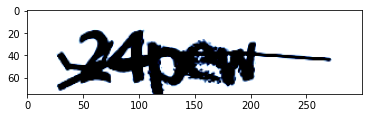

In [21]:
# plotting IMage
img = train_dataset[0]["images"].numpy()
plt.imshow(np.transpose(img,(1,2,0)))

In [22]:
temp_lbl = train_dataset[0]["targets"].numpy()
print(temp_lbl)

[ 1  3 16 11 17]


In [23]:
example = next(iter(test_dataloader))
print(example.keys())

dict_keys(['images', 'targets'])


In [24]:
print(example["images"].size())
print(example["targets"].size())

torch.Size([16, 3, 75, 300])
torch.Size([16, 5])


In [28]:
model = OCRModel(num_chars=numc)
model.to(DEVICE)

OCRModel(
  (conv_1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1152, out_features=64, bias=True)
  (lstm): GRU(64, 32, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (linear2): Linear(in_features=64, out_features=20, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)

In [29]:
def train_fn(model,loader,optimizer):
    model.train()
    total_loss = 0
    tk = tqdm(loader,total=len(loader))
    for d in tk:
        for k,v in d.items():
            d[k] = v.to(DEVICE)
        optimizer.zero_grad()
        _,loss = model(**d)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/(len(loader))

In [30]:
# Testing train_fn

#print(train_fn(model,train_dataloader,optimizer=opt))


In [31]:
def eval_fn(model,loader):
    with torch.no_grad():
        model.eval()
        val_losses = 0
        preds=[]
        tk = tqdm(loader,total=len(loader))
        for d in tk:
            for k,v in d.items():
                d[k] = v.to(DEVICE)
            pred,loss = model(**d)
            val_losses += loss.item()
            preds.append(pred)
    return preds,val_losses/(len(loader))

In [32]:
numc = len(lbl.classes_)
numc


19

In [33]:
# Training Loop

In [34]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

from sklearn import metrics

In [35]:
# We need to decode the predictions

def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j, :]:
            k = k - 1
            if k == -1:
                temp.append("§")
            else:
                p = encoder.inverse_transform([k])[0]
                temp.append(p)
        tp = "".join(temp).replace("§", "")
        cap_preds.append(remove_duplicates(tp))
    return cap_preds




In [36]:
def remove_duplicates(x):
    if len(x) < 2:
        return x
    fin = ""
    for j in x:
        if fin == "":
            fin = j
        else:
            if j == fin[-1]:
                continue
            else:
                fin = fin + j
    return fin


In [37]:
def run():
    for epoch in range(epochs):
        train_loss = train_fn(model,train_dataloader,optimizer=opt)
        predictions,eval_loss = eval_fn(model,test_dataloader)
        valid_preds = []

        for pred in predictions:
            current_preds = decode_predictions(pred,lbl)
            valid_preds.extend(current_preds)
        combined = list(zip(test_true_labesls,valid_preds))
        print(combined[:10])
        test_dup_rem = [remove_duplicates(c) for c in test_true_labesls]
        accuracy = metrics.accuracy_score(test_dup_rem,valid_preds)
        

        print(
                f"Epoch={epoch}, Train Loss={train_loss}, Test Loss={eval_loss} Accuracy={accuracy} "
            )

In [38]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [39]:
run()


[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=0, Train Loss=15.568090737876245, Test Loss=4.160199165344238 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=1, Train Loss=3.6957044480210643, Test Loss=3.326787437711443 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=2, Train Loss=3.322657964997372, Test Loss=3.2889680521828786 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=3, Train Loss=3.282950587191824, Test Loss=3.28129403931754 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=4, Train Loss=3.271115153522815, Test Loss=3.275997911180769 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=5, Train Loss=3.2675457606881353, Test Loss=3.2736009870256697 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=6, Train Loss=3.2664632676011425, Test Loss=3.2730042253221785 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=7, Train Loss=3.2658861491639737, Test Loss=3.2731310640062605 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=8, Train Loss=3.2651618981765487, Test Loss=3.27204316002982 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=9, Train Loss=3.265348951695329, Test Loss=3.2716616562434604 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=10, Train Loss=3.2646801875809492, Test Loss=3.2704920768737793 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=11, Train Loss=3.2647211309206687, Test Loss=3.2721151624407088 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=12, Train Loss=3.264824426780313, Test Loss=3.270376648221697 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=13, Train Loss=3.2651273153596003, Test Loss=3.2719023568289622 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=14, Train Loss=3.2650902230860823, Test Loss=3.2711472511291504 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=15, Train Loss=3.2655487383826305, Test Loss=3.2723702703203474 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=16, Train Loss=3.2650323520272466, Test Loss=3.2688022681644986 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=17, Train Loss=3.2638166395284363, Test Loss=3.2697299207959856 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=18, Train Loss=3.2640641584234724, Test Loss=3.2690352371760776 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=19, Train Loss=3.264412075786267, Test Loss=3.2686166763305664 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=20, Train Loss=3.2637375532570534, Test Loss=3.268302781241281 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=21, Train Loss=3.263314473426948, Test Loss=3.266569069453648 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=22, Train Loss=3.2634254229270807, Test Loss=3.2662943431309293 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=23, Train Loss=3.2628169544672563, Test Loss=3.2675273418426514 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=24, Train Loss=3.26183894529181, Test Loss=3.26623603275844 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=25, Train Loss=3.260489290043459, Test Loss=3.2683603763580322 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=26, Train Loss=3.255269858796718, Test Loss=3.2656040532248363 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=27, Train Loss=3.248689506013515, Test Loss=3.2540242671966553 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=28, Train Loss=3.2361913091045316, Test Loss=3.2373223985944475 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=29, Train Loss=3.2176109612998314, Test Loss=3.2111691747392928 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=30, Train Loss=3.1934625334658864, Test Loss=3.1712910447801863 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=31, Train Loss=3.1596383684772555, Test Loss=3.1196277482169017 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=32, Train Loss=3.1172894421270336, Test Loss=3.0928275925772533 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=33, Train Loss=3.0687732696533203, Test Loss=3.0383808272225514 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=34, Train Loss=3.0115378024214405, Test Loss=2.973083291734968 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=35, Train Loss=2.9378902144351247, Test Loss=2.901923963001796 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=36, Train Loss=2.8325937723709367, Test Loss=2.7148267882210866 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '')]
Epoch=37, Train Loss=2.7003881203926214, Test Loss=2.5251219613211497 Accuracy=0.0 



[('4dw3w', ''), ('bgd4m', ''), ('4n2yg', ''), ('cffp4', ''), ('d2ycw', ''), ('w52fn', ''), ('fc6xb', ''), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '6')]
Epoch=38, Train Loss=2.5096443305581304, Test Loss=2.3084032194955006 Accuracy=0.0 



[('4dw3w', '4'), ('bgd4m', 'g4'), ('4n2yg', '42y'), ('cffp4', '4'), ('d2ycw', '2'), ('w52fn', '2'), ('fc6xb', '6'), ('7pn5g', ''), ('5nxnn', ''), ('6cm6m', '6')]
Epoch=39, Train Loss=2.30587484472889, Test Loss=2.057376265525818 Accuracy=0.0 



[('4dw3w', '4'), ('bgd4m', 'g4'), ('4n2yg', '42y'), ('cffp4', '4'), ('d2ycw', '2y'), ('w52fn', '2'), ('fc6xb', '6'), ('7pn5g', 'g'), ('5nxnn', '5'), ('6cm6m', '6')]
Epoch=40, Train Loss=2.085962865312221, Test Loss=1.823574389730181 Accuracy=0.0 



[('4dw3w', '4'), ('bgd4m', 'g4'), ('4n2yg', '42yg'), ('cffp4', 'fp4'), ('d2ycw', '2y'), ('w52fn', '2'), ('fc6xb', '6'), ('7pn5g', 'p5g'), ('5nxnn', '5'), ('6cm6m', '6')]
Epoch=41, Train Loss=1.8464458473658159, Test Loss=1.556952851159232 Accuracy=0.0 



[('4dw3w', '4'), ('bgd4m', 'g4'), ('4n2yg', '42yg'), ('cffp4', 'fp4'), ('d2ycw', '2y'), ('w52fn', '52f'), ('fc6xb', '6'), ('7pn5g', 'p5g'), ('5nxnn', '5'), ('6cm6m', '6')]
Epoch=42, Train Loss=1.6157487287359722, Test Loss=1.3323822362082345 Accuracy=0.019230769230769232 



[('4dw3w', '4d3'), ('bgd4m', 'gd4'), ('4n2yg', '42yg'), ('cffp4', 'fp4'), ('d2ycw', 'd2yw'), ('w52fn', 'w52f'), ('fc6xb', 'fc6'), ('7pn5g', '7p5g'), ('5nxnn', '5'), ('6cm6m', '6')]
Epoch=43, Train Loss=1.3991088139808785, Test Loss=1.1140612193516322 Accuracy=0.0673076923076923 



[('4dw3w', '4dw3w'), ('bgd4m', '8gd4'), ('4n2yg', '42yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52f'), ('fc6xb', 'fc6b'), ('7pn5g', '7p5g'), ('5nxnn', '5x'), ('6cm6m', '6c6')]
Epoch=44, Train Loss=1.2033588502366663, Test Loss=0.9270418626921517 Accuracy=0.15384615384615385 



[('4dw3w', '4dw3w'), ('bgd4m', '8gd4'), ('4n2yg', '42yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52f'), ('fc6xb', 'fc6xb'), ('7pn5g', '7p5g'), ('5nxnn', '5xn'), ('6cm6m', '6c6')]
Epoch=45, Train Loss=1.0293560967607014, Test Loss=0.7732110108648028 Accuracy=0.36538461538461536 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6b'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6c6')]
Epoch=46, Train Loss=0.884523430113065, Test Loss=0.6461076651300702 Accuracy=0.5 



[('4dw3w', '4dw3w'), ('bgd4m', '6gd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52f'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6c6')]
Epoch=47, Train Loss=0.7536053788864007, Test Loss=0.5524099596909114 Accuracy=0.5769230769230769 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=48, Train Loss=0.6590111892102128, Test Loss=0.4796720104558127 Accuracy=0.7019230769230769 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=49, Train Loss=0.5874784795914666, Test Loss=0.4292636982032231 Accuracy=0.6634615384615384 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=50, Train Loss=0.5239956535525241, Test Loss=0.3880384010928018 Accuracy=0.6923076923076923 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=51, Train Loss=0.4852623131315587, Test Loss=0.37038844398089815 Accuracy=0.6923076923076923 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=52, Train Loss=0.4358693325923661, Test Loss=0.3260930989469801 Accuracy=0.7019230769230769 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=53, Train Loss=0.40944798871622246, Test Loss=0.30777143367699217 Accuracy=0.7019230769230769 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=54, Train Loss=0.3794737513792717, Test Loss=0.3070872553757259 Accuracy=0.7211538461538461 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=55, Train Loss=0.350214981679189, Test Loss=0.2774710123028074 Accuracy=0.7211538461538461 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=56, Train Loss=0.32878604506031944, Test Loss=0.26286391488143374 Accuracy=0.7115384615384616 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=57, Train Loss=0.30744831895424146, Test Loss=0.2433080737079893 Accuracy=0.7211538461538461 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=58, Train Loss=0.2930642783136691, Test Loss=0.2482944897242955 Accuracy=0.6923076923076923 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=59, Train Loss=0.2854861978252055, Test Loss=0.2284398078918457 Accuracy=0.7115384615384616 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=60, Train Loss=0.2720049286292771, Test Loss=0.22700639069080353 Accuracy=0.7596153846153846 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=61, Train Loss=0.24931837618350983, Test Loss=0.20655100047588348 Accuracy=0.7596153846153846 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=62, Train Loss=0.2420156614507659, Test Loss=0.20769938400813512 Accuracy=0.7596153846153846 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=63, Train Loss=0.2371092592760668, Test Loss=0.21362967150551931 Accuracy=0.8173076923076923 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=64, Train Loss=0.220698972627268, Test Loss=0.17214472804750716 Accuracy=0.7884615384615384 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=65, Train Loss=0.21354413386118615, Test Loss=0.1733953058719635 Accuracy=0.8269230769230769 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=66, Train Loss=0.2018330100986917, Test Loss=0.15991507470607758 Accuracy=0.8173076923076923 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=67, Train Loss=0.19039084724450517, Test Loss=0.15124908621822084 Accuracy=0.8173076923076923 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=68, Train Loss=0.18823041968931586, Test Loss=0.14754942591701234 Accuracy=0.8076923076923077 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=69, Train Loss=0.17937271814730207, Test Loss=0.14561995651040757 Accuracy=0.8269230769230769 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=70, Train Loss=0.17511489810579914, Test Loss=0.13704235319580352 Accuracy=0.7884615384615384 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6m')]
Epoch=71, Train Loss=0.16307149221331385, Test Loss=0.13346292397805623 Accuracy=0.8461538461538461 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6m')]
Epoch=72, Train Loss=0.15689866181652426, Test Loss=0.1182828311409269 Accuracy=0.8557692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=73, Train Loss=0.14620472553928018, Test Loss=0.11256417206355504 Accuracy=0.8461538461538461 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6m')]
Epoch=74, Train Loss=0.13359882531024642, Test Loss=0.10943362010376793 Accuracy=0.8557692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6')]
Epoch=75, Train Loss=0.13325948078753586, Test Loss=0.10323944900717054 Accuracy=0.8653846153846154 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6m')]
Epoch=76, Train Loss=0.13132827615333817, Test Loss=0.1008810315813337 Accuracy=0.8557692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=77, Train Loss=0.11761885287903123, Test Loss=0.08095600136688777 Accuracy=0.9423076923076923 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=78, Train Loss=0.11267540502851292, Test Loss=0.08192246407270432 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4n'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cn6m')]
Epoch=79, Train Loss=0.10473771229133767, Test Loss=0.07592229172587395 Accuracy=0.9615384615384616 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6')]
Epoch=80, Train Loss=0.09377297575948602, Test Loss=0.06063999608159065 Accuracy=0.9615384615384616 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=81, Train Loss=0.09259568243208578, Test Loss=0.05502520341958318 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=82, Train Loss=0.08349486882403745, Test Loss=0.04484102821775845 Accuracy=0.9711538461538461 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=83, Train Loss=0.06912948058570846, Test Loss=0.051377094217709134 Accuracy=0.9711538461538461 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=84, Train Loss=0.0705258029876119, Test Loss=0.043233796155878475 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=85, Train Loss=0.06298900720805435, Test Loss=0.0407147796026298 Accuracy=0.9711538461538461 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=86, Train Loss=0.05995448344087197, Test Loss=0.03476859602544989 Accuracy=0.9519230769230769 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=87, Train Loss=0.05323571932770438, Test Loss=0.032797282694705894 Accuracy=0.9711538461538461 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=88, Train Loss=0.051718513370823053, Test Loss=0.03715455452246325 Accuracy=0.9519230769230769 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=89, Train Loss=0.04639745033267191, Test Loss=0.025961017502205714 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=90, Train Loss=0.04518442862998631, Test Loss=0.0275096097694976 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=91, Train Loss=0.04720361322417098, Test Loss=0.025924944318830967 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=92, Train Loss=0.04116450575322418, Test Loss=0.025086961553565094 Accuracy=0.9615384615384616 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=93, Train Loss=0.0476173019447064, Test Loss=0.025540351335491453 Accuracy=0.9711538461538461 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=94, Train Loss=0.03422447395021633, Test Loss=0.027264722090746676 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=95, Train Loss=0.030546198993668717, Test Loss=0.022185949874775752 Accuracy=0.9711538461538461 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=96, Train Loss=0.03188237023808188, Test Loss=0.01958521575267826 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=97, Train Loss=0.03397467928165096, Test Loss=0.021588011511734555 Accuracy=0.9711538461538461 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=98, Train Loss=0.03215436304335372, Test Loss=0.01944094098040036 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=99, Train Loss=0.031125415274399822, Test Loss=0.024446585747812475 Accuracy=0.9615384615384616 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=100, Train Loss=0.03143792627852852, Test Loss=0.034483417469475953 Accuracy=0.9711538461538461 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=101, Train Loss=0.03213488840955799, Test Loss=0.02233666939926999 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=102, Train Loss=0.025851914974845062, Test Loss=0.0159345763469381 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=103, Train Loss=0.02555881314358469, Test Loss=0.026280850305088928 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=104, Train Loss=0.023622908708402664, Test Loss=0.018165595164256438 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=105, Train Loss=0.02208013134866448, Test Loss=0.01373431525592293 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=106, Train Loss=0.021472393108879106, Test Loss=0.017694867282573665 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=107, Train Loss=0.018983930428275616, Test Loss=0.013366777183754104 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=108, Train Loss=0.01923074262311398, Test Loss=0.013882702549121209 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=109, Train Loss=0.02606586747313455, Test Loss=0.024448680824467113 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=110, Train Loss=0.01790365729859825, Test Loss=0.016512780583330562 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=111, Train Loss=0.016103938955939926, Test Loss=0.022261797250913724 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=112, Train Loss=0.019207891329365262, Test Loss=0.022236168018675277 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=113, Train Loss=0.016830603165899294, Test Loss=0.018905107464109148 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=114, Train Loss=0.01692986992677137, Test Loss=0.014863002712705306 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=115, Train Loss=0.018285830813002283, Test Loss=0.012275644444993563 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=116, Train Loss=0.014500050521376779, Test Loss=0.012508517463824578 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=117, Train Loss=0.01292139006052482, Test Loss=0.014621649270078965 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=118, Train Loss=0.014450113510050006, Test Loss=0.014463425281324558 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=119, Train Loss=0.014250185932585244, Test Loss=0.015049576559769256 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=120, Train Loss=0.013818360296851498, Test Loss=0.01845518928686423 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=121, Train Loss=0.017570047331500357, Test Loss=0.02413194260693022 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=122, Train Loss=0.016509596384682898, Test Loss=0.016401402752048204 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=123, Train Loss=0.013349000001484054, Test Loss=0.012583126480291997 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=124, Train Loss=0.014791789456759975, Test Loss=0.015486645079883081 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=125, Train Loss=0.013595894144816418, Test Loss=0.015330456363569413 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=126, Train Loss=0.011767969261539184, Test Loss=0.012656795459666423 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=127, Train Loss=0.011873374795699018, Test Loss=0.013499482268733638 Accuracy=0.9711538461538461 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=128, Train Loss=0.01848347418767921, Test Loss=0.009900707019759076 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=129, Train Loss=0.016167566290725084, Test Loss=0.01771895321352141 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=130, Train Loss=0.011998561802872662, Test Loss=0.014212981431878038 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=131, Train Loss=0.007687994559153409, Test Loss=0.01027163934694337 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=132, Train Loss=0.011486538606932608, Test Loss=0.020677008400005952 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=133, Train Loss=0.012853855385555554, Test Loss=0.014255101725991284 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=134, Train Loss=0.009212071912647304, Test Loss=0.016983535706198642 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=135, Train Loss=0.0074334959104909734, Test Loss=0.01469374612705516 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=136, Train Loss=0.010277681257891453, Test Loss=0.01120802785070347 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=137, Train Loss=0.007540493860240962, Test Loss=0.017160523000971546 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=138, Train Loss=0.008147168651980868, Test Loss=0.016614121235241846 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=139, Train Loss=0.011395919436620454, Test Loss=0.026465092918702533 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=140, Train Loss=0.007744966453667414, Test Loss=0.009301481053366192 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=141, Train Loss=0.006237449712451484, Test Loss=0.010156429788496877 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=142, Train Loss=0.006665457454431108, Test Loss=0.015251621154935233 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=143, Train Loss=0.007915919496662031, Test Loss=0.01696410387687917 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=144, Train Loss=0.005885711713236267, Test Loss=0.013704788155986794 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=145, Train Loss=0.008947496831227662, Test Loss=0.021886215794698467 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=146, Train Loss=0.008917582568602037, Test Loss=0.014580433273554913 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=147, Train Loss=0.004826186982504392, Test Loss=0.01924643399459975 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=148, Train Loss=0.0074145908278050055, Test Loss=0.027071978331410458 Accuracy=0.9711538461538461 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=149, Train Loss=0.00671014973451778, Test Loss=0.016933241676140045 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=150, Train Loss=0.006161749775332036, Test Loss=0.01603278291544744 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=151, Train Loss=0.005837625220133844, Test Loss=0.03210570999986625 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=152, Train Loss=0.006241270842156925, Test Loss=0.02016916435344943 Accuracy=0.9711538461538461 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=153, Train Loss=0.005751176372217804, Test Loss=0.024100515941557075 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=154, Train Loss=0.009585089018663107, Test Loss=0.012103204390898879 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=155, Train Loss=0.004215909030004326, Test Loss=0.00317889654044328 Accuracy=1.0 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=156, Train Loss=0.005663763392337803, Test Loss=0.01398726215120405 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=157, Train Loss=0.006191261229105294, Test Loss=0.006626680194001112 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=158, Train Loss=0.0044243530926720825, Test Loss=0.006656971211279077 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=159, Train Loss=0.0080553213750028, Test Loss=0.009990141444307352 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=160, Train Loss=0.010963442573576407, Test Loss=0.012155689997598529 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=161, Train Loss=0.009686518144809593, Test Loss=0.01556748358000602 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=162, Train Loss=0.012694134234876956, Test Loss=0.013648050587757357 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=163, Train Loss=0.005421292054530044, Test Loss=0.021371783522356833 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=164, Train Loss=0.0067872964023312525, Test Loss=0.03203090155563716 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2yew'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=165, Train Loss=0.00632862687126686, Test Loss=0.039889298944867084 Accuracy=0.9615384615384616 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=166, Train Loss=0.006377202969723207, Test Loss=0.007823589257895947 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=167, Train Loss=0.004189710493862502, Test Loss=0.012417754482677472 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=168, Train Loss=0.0040571047052330635, Test Loss=0.0149361000346419 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=169, Train Loss=0.010584391722597687, Test Loss=0.022357093785623356 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=170, Train Loss=0.008040361021550656, Test Loss=0.015027887977859271 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=171, Train Loss=0.009843510494693735, Test Loss=0.02096455149252766 Accuracy=0.9711538461538461 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=172, Train Loss=0.00433188007544663, Test Loss=0.027777599877611334 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=173, Train Loss=0.0038293816772747343, Test Loss=0.01669030378772212 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=174, Train Loss=0.0026004328017549243, Test Loss=0.01600325869263283 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=175, Train Loss=0.003049496454739217, Test Loss=0.010215652042201586 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=176, Train Loss=0.0019365139009620426, Test Loss=0.02168237911869905 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=177, Train Loss=0.002054062792321004, Test Loss=0.013216368712684405 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=178, Train Loss=0.0036635318991996473, Test Loss=0.011458528926596045 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=179, Train Loss=0.0021282884241002847, Test Loss=0.016431156329677572 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=180, Train Loss=0.004343490379712529, Test Loss=0.006414178987532588 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=181, Train Loss=0.003126905301696289, Test Loss=0.008977598552259483 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=182, Train Loss=0.002645554340649712, Test Loss=0.06399328470329887 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=183, Train Loss=0.003204746481615229, Test Loss=0.014134392021722826 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=184, Train Loss=0.0033279992373644422, Test Loss=0.026155257152692814 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=185, Train Loss=0.0023328340464366317, Test Loss=0.013449770298653416 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=186, Train Loss=0.0014750768866595198, Test Loss=0.012662859816503311 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=187, Train Loss=0.0023047186895983956, Test Loss=0.013210423660763939 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=188, Train Loss=0.004834083213778686, Test Loss=0.007938946389393615 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=189, Train Loss=0.006446728568674081, Test Loss=0.011967698872987447 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=190, Train Loss=0.003734812035888307, Test Loss=0.010128840097292726 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=191, Train Loss=0.0019171586915282374, Test Loss=0.013181706291756459 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=192, Train Loss=0.004075866886138348, Test Loss=0.015179168649150856 Accuracy=0.9711538461538461 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=193, Train Loss=0.002610268613907619, Test Loss=0.010503645574707272 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=194, Train Loss=0.0029738928562314327, Test Loss=0.012449824941411083 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=195, Train Loss=0.0038450462181294745, Test Loss=0.009419839313652898 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=196, Train Loss=0.012059127382136945, Test Loss=0.0030193075196750995 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=197, Train Loss=0.011062377771773076, Test Loss=0.02228790016046592 Accuracy=0.9807692307692307 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=198, Train Loss=0.005870215476380061, Test Loss=0.010248045861122332 Accuracy=0.9903846153846154 



[('4dw3w', '4dw3w'), ('bgd4m', 'bgd4m'), ('4n2yg', '4n2yg'), ('cffp4', 'cfp4'), ('d2ycw', 'd2ycw'), ('w52fn', 'w52fn'), ('fc6xb', 'fc6xb'), ('7pn5g', '7pn5g'), ('5nxnn', '5nxn'), ('6cm6m', '6cm6m')]
Epoch=199, Train Loss=0.0034295429359190166, Test Loss=0.01167100207697201 Accuracy=0.9807692307692307 


ERROR:root:File `'().py'` not found.
